# Finite Element Method

![image](\img\esquematico.png)

In [321]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt

pi = np.pi

In [322]:
# Definição dos parâmetros da viga
L = 1.5                             # Comprimento da viga [m]
L1 = 0.0                            # Dividir a viga em seções
L2 = L/3
L3 = 2*L/3
rho = 7700                          # Densidade do material [kg/m**3]
E = 2.1e11                          # Modulo de elasticidade [Pa]
A1 = pi * 0.03**2 / 4               # Área da seção 1 [m**2]
A2 = pi * 0.06**2 / 4               # Área da seção 2 [m**2]
A3 = pi * 0.03**2 / 4               # Área da seção 3 [m**2]
I1 = (pi/4)*(0.03/2)**4             # Momento da seção 1 [m**4] 
I2 = (pi/4)*(0.06/2)**4             # Momento da seção 2 [m**4]
I3 = (pi/4)*(0.03/2)**4             # Momento da seção 3 [m**4]
m_eng = 20                          # Massa da engrenagem [kg]
J_eng = 0.25 * m_eng * 0.1**2       # Momento de inercia de massa da engreagem [kg*m**2]
k_mola = 2*10e3                     # Rigidez esquivalente das molas em paralelo [N/m]



def M_e(rho, A, a):
    return rho*A*a/105*np.array([[78, 22*a, 27, -13*a], [22*a, 8*a**2, 13*a, -6*a**2], [27, 13*a, 78, -22*a], [-13*a, -6*a**2, -22*a, 8*a**2]])

def K_e(E, I, a):
    return E*I/(2*a**3)*np.array([[3, 3*a, -3, 3*a], [3*a, 4*a**2, -3*a, 2*a**2], [-3, -3*a, 3, -3*a], [3*a, 2*a**2, -3*a, 4*a**2]])

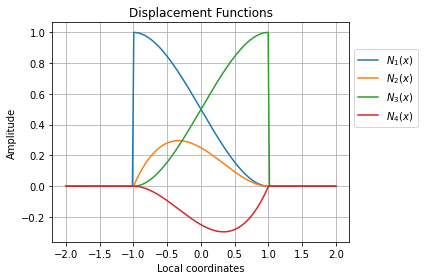

In [323]:
def N1(xi):
    return np.piecewise(xi, [xi<-1, xi>=-1, xi>1], [0, lambda xi: 0.25*(2 - 3*xi + xi**3), 0])
def N2(xi):
    return np.piecewise(xi, [xi<-1, xi>=-1, xi>1], [0, lambda xi: 0.25*(1 - xi - xi**2 + xi**3), 0])
def N3(xi):
    return np.piecewise(xi, [xi<-1, xi>=-1, xi>1], [0, lambda xi: 0.25*(2 + 3*xi - xi**3), 0])
def N4(xi):
    return np.piecewise(xi, [xi<-1, xi>=-1, xi>1], [0, lambda xi: 0.25*(-1 - xi + xi**2 + xi**3), 0])  

x = np.linspace(-2, 2, 200)
plt.plot(x, N1(x))
plt.plot(x, N2(x))
plt.plot(x, N3(x))
plt.plot(x, N4(x))
plt.title("Displacement Functions")
plt.xlabel("Local coordinates")
plt.ylabel("Amplitude")
plt.legend([f'$N_1(x)$', f'$N_2(x)$',f'$N_3(x)$',f'$N_4(x)$'], loc='upper left', bbox_to_anchor=(1, 0.9))
plt.grid()
plt.tight_layout()
plt.savefig("img/displacement_functions.pdf")
plt.show()


## Determinando as matrizes de massa e rigidez

In [324]:
# Matriz de massa pontual e momento de inércia de massa
MJ = np.zeros((4,4))
MJ[2,2] = m_eng
MJ[3,3] = J_eng

# Matriz de rigidez pontual
Keq = np.zeros((4,4))
Keq[2,2] = k_mola

n = np.array([9, 18, 720])                  # Array com os numeros de elementos
resultados = dict()

for N in n:
    L_el = L/N                             # comprimento do elemento [m]
    a = L_el/2
    nodes = N + 1                          # Número de nós
    coord = np.linspace(0, L, N)           # coordenadas dos nós
    Ngl = 2*nodes                          # Número de graus de liberdade, dois por nó
    
    K = np.zeros((Ngl, Ngl))               # Pre-alocando matriz de rigidez
    M = np.zeros((Ngl, Ngl))               # Pre-alocando matriz de massa

    # Montando as matrizes de massa e rigidez
    for j in range(1, N+1):
        pos = j*L_el

        # First beam segment
        if pos > L1 and pos <= L2:
            if pos==L2: # Gear inertia
                M[(2*j-2):(2*j+2),(2*j-2):(2*j+2)] += M_e(rho, A1, a) + MJ
            else:
                M[(2*j-2):(2*j+2),(2*j-2):(2*j+2)] += M_e(rho, A1, a)
            K[(2*j-2):(2*j+2),(2*j-2):(2*j+2)] += K_e(E, I1, a)
        # Second beam segment
        elif pos > L2 and pos <= L3:
            M[(2*j-2):(2*j+2),(2*j-2):(2*j+2)] += M_e(rho, A2, a)
            if pos==L3: # Springs stiffness
                K[(2*j-2):(2*j+2),(2*j-2):(2*j+2)] += K_e(E, I2, a) + Keq
            else:
                K[(2*j-2):(2*j+2),(2*j-2):(2*j+2)] += K_e(E, I2, a)
        # Third beam segment
        elif pos > L3:
            M[(2*j-2):(2*j+2),(2*j-2):(2*j+2)] += M_e(rho, A3, a)
            K[(2*j-2):(2*j+2),(2*j-2):(2*j+2)] += K_e(E, I3, a)

    
    # Aplicando as condicoes de contorno geometricas
    cc = np.array([1, 2]) # Graus de Liberdade que devem ser restritos
    # Ordenando os GL para mais tarde reinserir na matrix de modos
    idx = cc.argsort()
    cc = cc[idx]

    M = np.delete(M, cc - 1, axis=1)
    M = np.delete(M, cc - 1, axis=0)
    K = np.delete(K, cc - 1, axis=1)
    K = np.delete(K, cc - 1, axis=0)

    # Problema de autovalor generalizado. W é um vetor e A uma matrix com as colunas normalizadas
    # Make [M] and [K] into an sparse matrix object
    M2 = sp.sparse.bsr_matrix(M)
    K2 = sp.sparse.bsr_matrix(K)
    k = 40 if N > 40 else N
    W, Vc = eigsh(A=K2, k=k, M=M2, which='LM', sigma=0, mode='normal')

    # Ordenando os autovalores e a matriz de autovetores
    idx = W.argsort()
    W = W[idx]
    Vc = Vc[:,idx]

    # Normalizando os autovetores pela matriz de massa, de forma que A'@M@A = I
    m_r = np.diagonal(Vc.T @ M2 @ Vc)
    m_r = np.reciprocal(np.sqrt(m_r))
    for a in range(Vc.shape[1]):
        Vc[:,a] *= m_r[a] # multiplica cada coluna pelo fator de escala
       
    ## Montando as formas modais
    # Incluindo os GL das condições de contorno
    for c in cc:
        Vc = np.insert(Vc, c-1, 0, axis=0)

    resultados[N] = dict()
    resultados[N]['fn'] = (W**0.5/(2*pi)).real
    resultados[N]['x'] = np.arange(0, L+L_el, L_el)
    resultados[N]['V'] = Vc[0::2, :] # Modos de deslocamento (Gl 1,3,5,...) 
    resultados[N]['theta'] = Vc[1::2, :] # Modos angulares (Gl 2,4,6,...)
    resultados[N]['M'] = M
    resultados[N]['K'] = K

    # # Faz as formas modais terem a mesma orientação
    # for j in range(1, W.size):
    #     if np.sum(resultados[N]['V'][:,j-1]) >= 0:
    #         pass
    #     else:
    #         resultados[N]['V'][:,j-1] *= -1


# Frequências Naturais

In [325]:
pd.options.display.float_format = "{:.2f}".format
pd.DataFrame(data=[resultados[n_b]['fn'] for n_b in n], index=[f"n={i}" for i in n], columns=[f"f_{j}" for j in range(1, len(resultados[n.max()]['fn'])+1)])

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_31,f_32,f_33,f_34,f_35,f_36,f_37,f_38,f_39,f_40
n=9,9.67,44.26,124.22,441.03,570.93,725.63,1257.99,1587.24,1735.38,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n=18,9.67,44.26,124.21,440.37,568.94,723.76,1249.63,1560.45,1723.68,2767.03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n=720,9.67,44.26,124.20,440.32,568.79,723.60,1248.85,1557.42,1721.06,2756.58,...,28497.38,32412.94,32553.87,35438.17,38459.54,38879.77,43231.03,44858.14,46099.90,51233.31


## Comparação das frequências naturais

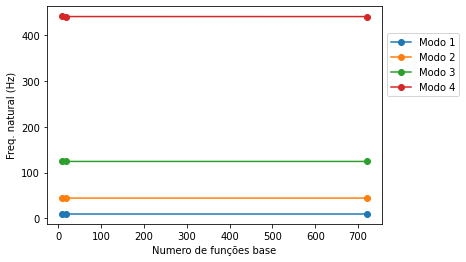

In [326]:
fn_N=np.zeros((4, len(n)))
for j in range(0,4): # numero de modos
    for k in range(len(n)): # Número de simulações
        fn_N[j, k] = resultados[n[k]]['fn'][j]
        
for j in range(fn_N[:,0].size):
    plt.plot(n, fn_N[j,:], marker='o')

plt.xlabel('Numero de funções base')
plt.ylabel('Freq. natural (Hz)')
plt.legend(['Modo 1', 'Modo 2','Modo 3', 'Modo 4'], loc='upper left', bbox_to_anchor=(1, 0.9))
plt.show()

# Formas Modais

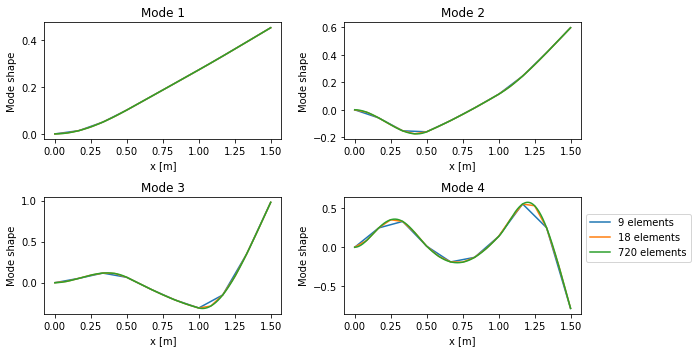

In [327]:
modes = [0,1,2,3]
fig = plt.figure()
for i in range(1,5):
    plt.subplot(2, 2, i)
    mode = modes[i-1]
    for N in n:
        x = np.linspace(0, L, len(resultados[N]['V'][:,mode]))
        v = resultados[N]['V'][:,mode]
        # make mode have the same orientation for comparisson
        if np.sum(v) >= 0:
            pass
        else:
            v *= -1

        plt.title(f'Mode {mode+1}')
        plt.plot(x, v, label=f"{N} elements")
        plt.xlabel('x [m]')
        plt.ylabel('Mode shape')

plt.legend(loc='upper left', bbox_to_anchor=(1, 0.9))
# plt.figure(figsize=(8,8))
fig.set_size_inches(10,5)
plt.tight_layout()
plt.show()

In [351]:
def x_to_xi(x, x1, x2):
    """Change global (x) to local (xi) coordinate system"""
    return 2*(x-x1)/(x2-x1)-1 - np.finfo(float).eps

def interp(x, mode=3, N=9, a=a):
    dx = L/N                             # comprimento do elemento [m]
    a = dx/2
    node_coor = np.linspace(0, L, N+1)
    element_con = np.array([np.arange(1,N+1), np.arange(2,N+2)]).T # row 0 -> element 1: conects nodes 1 and 2
    v = v1 = v2 = np.zeros(len(x))
    for element in range(N):
        node = element_con[element]-1
        # generalized coordinates
        v_e = np.array([resultados[N]['V'][node[0],mode], 
               -a*resultados[N]['theta'][node[0],mode],
               resultados[N]['V'][node[1],mode],
               -a*resultados[N]['theta'][node[1],mode]])
        x1 = node_coor[node[0]]
        x2 = node_coor[node[1]]

        d1_1 = v_e[2]-v_e[0]
        d1_2 = resultados[N]['V'][node[0]+1,mode] - v_e[2]
        curvature = 1 if d1_2 <= d1_1 else -1
        if (v_e[3] - v_e[1])*curvature:
            pass
        else:
            v_e[1] *= -1
            v_e[3] *= -1


        v += v_e[0]*N1(x_to_xi(x, x1, x2))
        v += v_e[1]*N2(x_to_xi(x, x1, x2))
        v += v_e[2]*N3(x_to_xi(x, x1, x2))
        v += v_e[3]*N4(x_to_xi(x, x1, x2))
    return v



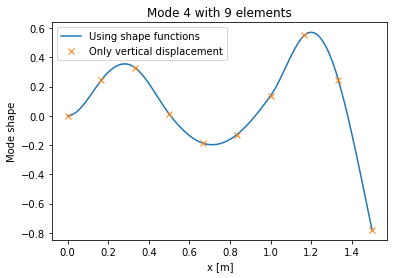

In [363]:
N=9
mode=3
x = np.linspace(0, L, 100)
v = interp(x, mode=mode, N=N)

# make mode have the same orientation for comparisson
if np.sum(v)>=0:
    pass
else:
    v*=-1
plt.plot(x, v, label="Using shape functions")

x = np.linspace(0, L, len(resultados[N]['V'][:,0]))
v2 = resultados[N]['V'][:,mode]
if np.sum(v2)>=0:
    pass
else:
    v2*=-1
plt.plot(x, v2, 'x', label="Only vertical displacement")

plt.xlabel('x [m]')
plt.ylabel('Mode shape')
plt.title(f'Mode {mode+1} with {N} elements')
plt.legend()
fig.set_size_inches(8,5)
fig.tight_layout()
plt.savefig("img/mode_shapes_using_shape_function_vs_only_vertical_disp.pdf")
plt.show()
        

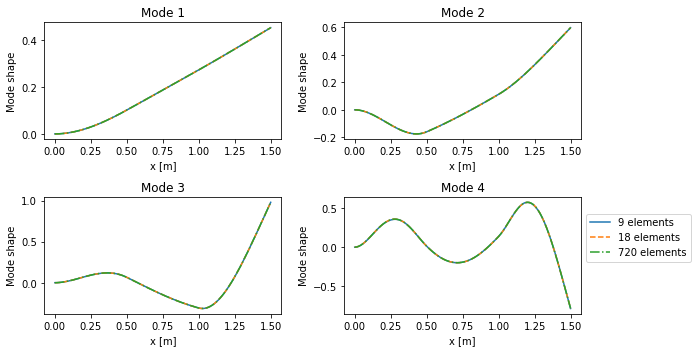

In [362]:
modes = [0,1,2,3]
linestyle = ['-', '--', '-.', ':']
fig = plt.figure()
for i in range(1,5):
    plt.subplot(2, 2, i)
    mode = modes[i-1]
    for i, N in enumerate(n):
        x = np.linspace(0, L, 100)
        v = interp(x, mode=mode, N=N)
        # make modes have the same orientation for comparisson
        if np.sum(v) >= 0:
            pass
        else:
            v *= -1

        plt.title(f'Mode {mode+1}')
        plt.plot(x, v, label=f"{N} elements", linestyle=linestyle[i])
        plt.xlabel('x [m]')
        plt.ylabel('Mode shape')

plt.legend(loc='upper left', bbox_to_anchor=(1, 0.9))
fig.set_size_inches(10,5)
plt.tight_layout()
plt.savefig("img/mode_shapes_using_shape_function.pdf")
plt.show()